# Movie Interest Prediction – Final Modeling


This notebook consolidates the end-to-end modeling workflow for the Movie Interest Prediction capstone. We evaluate three progressively complex models—cosine KNN, Random Forest, and a tuned neural network—using a user-stratified train/test split to avoid temporal leakage. Metrics focus on RMSE and MAE, with a dedicated cold-start analysis for low-coverage movies.


In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import sparse
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

from src.data import build_enriched_ratings
from src.features import FeatureBuilder
from src.modeling import (
    user_stratified_split,
    evaluate_regression,
    cold_start_mask,
    fit_baseline_knn,
    fit_random_forest,
    random_forest_feature_importance,
)

In [2]:
sns.set_theme(style="whitegrid", palette="deep")
np.random.seed(42)

In [3]:
DATA_DIR = Path(".") / "Data"
ML_PATH = DATA_DIR / "ml-100k"
TMDB_PATH = DATA_DIR / "TMDB-5000"
ratings_df = build_enriched_ratings(ML_PATH, TMDB_PATH)
ratings_df.shape

(100000, 23)

In [4]:
ratings_df = ratings_df.assign(
    timestamp=pd.to_datetime(ratings_df["timestamp"], unit="s"),
    tmdb_budget=ratings_df["tmdb_budget"].fillna(0),
    tmdb_runtime=ratings_df["tmdb_runtime"].fillna(ratings_df["tmdb_runtime"].median()),
    tmdb_vote_average=ratings_df["tmdb_vote_average"].fillna(ratings_df["tmdb_vote_average"].median()),
    tmdb_vote_count=ratings_df["tmdb_vote_count"].fillna(0),
    popularity=ratings_df["popularity"].fillna(ratings_df["popularity"].median()),
    release_year=ratings_df["release_year"].fillna(ratings_df["release_year"].median()),
)
ratings_df["genres_list"] = ratings_df["genres_list"].apply(lambda x: x if isinstance(x, list) else [])
ratings_df["top_cast"] = ratings_df["top_cast"].apply(lambda x: x if isinstance(x, list) else [])
ratings_df.head()

,user_id,movie_id,rating,timestamp,title,release_date,imdb_url,genres_list,top_cast,tmdb_movie_id,...,tmdb_release_date,tmdb_vote_average,tmdb_vote_count,popularity,title_clean,release_year,age,gender,occupation,zip_code
0,196,242,3,1997-12-04 15:55:49,Kolya (1996),24-Jan-1997,http://us.imdb.com/M/title-exact?Kolya%20(1996),[],[],NaN,...,NaN,7.0,0.0,30.884535,kolya,1997.0,49,M,writer,55105
1,186,302,3,1998-04-04 19:22:22,L.A. Confidential (1997),01-Jan-1997,http://us.imdb.com/M/title-exact?L%2EA%2E+Conf...,"[Crime, Drama, Mystery, Thriller]","[Kevin Spacey, Guy Pearce, Danny DeVito, James...",2118.0,...,1997-09-19,7.7,1310.0,24.860326,l a confidential,1997.0,39,F,executive,00000
2,22,377,1,1997-11-07 07:18:36,Heavyweights (1994),01-Jan-1994,http://us.imdb.com/M/title-exact?Heavyweights%...,[],[],NaN,...,NaN,7.0,0.0,30.884535,heavyweights,1994.0,25,M,writer,40206
3,244,51,2,1997-11-27 05:02:03,Legends of the Fall (1994),01-Jan-1994,http://us.imdb.com/M/title-exact?Legends%20of%...,"[Adventure, Drama, Romance, War]","[Brad Pitt, Anthony Hopkins, Aidan Quinn, Juli...",4476.0,...,1994-12-16,7.2,619.0,26.952727,legends of the fall,1994.0,28,M,technician,80525
4,166,346,1,1998-02-02 05:33:16,Jackie Brown (1997),01-Jan-1997,http://us.imdb.com/M/title-exact?imdb-title-11...,"[Comedy, Crime, Romance]","[Pam Grier, Samuel L. Jackson, Robert Forster,...",184.0,...,1997-12-24,7.3,1514.0,40.631671,jackie brown,1997.0,47,M,educator,55113


In [5]:
train_df, test_df = user_stratified_split(ratings_df, test_ratio=0.2, min_user_ratings=5, min_test_items=1)
len(train_df), len(test_df)

(79619, 20381)

In [6]:
feature_builder = FeatureBuilder(include_text=True, max_text_features=300, min_text_df=5)
X_train = feature_builder.fit_transform(train_df)
X_test = feature_builder.transform(test_df)
feature_names = feature_builder.get_feature_names()
X_train.shape, X_test.shape

((79619, 345), (20381, 345))

In [7]:
y_train = train_df["rating"].values
y_test = test_df["rating"].values

## Model 1: Cosine KNN Baseline


In [8]:
knn_model = fit_baseline_knn(X_train, y_train, n_neighbors=35, metric="cosine")
knn_pred = knn_model.predict(X_test)
knn_metrics = evaluate_regression(y_test, knn_pred)
knn_metrics

{'rmse': 1.1229938918522668, 'mae': 0.8828948523257931}

In [9]:
train_movie_counts = train_df.groupby("movie_id").size()
knn_cold_mask = cold_start_mask(test_df, train_movie_counts, min_count=5)
knn_cold_metrics = evaluate_regression(y_test[knn_cold_mask], knn_pred[knn_cold_mask]) if knn_cold_mask.any() else {}
knn_warm_metrics = evaluate_regression(y_test[~knn_cold_mask], knn_pred[~knn_cold_mask])
knn_cold_metrics, knn_warm_metrics

({'rmse': 1.272860650372192, 'mae': 1.0036336974949933},
 {'rmse': 1.1181175463365738, 'mae': 0.8792200060346835})

## Model 2: Random Forest with Grid Search


In [10]:
rf_param_grid = {
    "n_estimators": [200],
    "max_depth": [None, 40],
    "max_features": ["sqrt"],
    "min_samples_leaf": [1, 3],
}
cv = KFold(n_splits=3, shuffle=True, random_state=42)
rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=rf_param_grid,
    cv=cv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1,
)
rf_grid.fit(X_train, y_train)
rf_grid.best_params_, -rf_grid.best_score_

Fitting 3 folds for each of 4 candidates, totalling 12 fits


({'max_depth': 40,
  'max_features': 'sqrt',
  'min_samples_leaf': 3,
  'n_estimators': 200},
 0.9658600626385313)

In [11]:
rf_cv_results = pd.DataFrame(rf_grid.cv_results_)[[
    "params",
    "mean_test_score",
    "std_test_score"
]].assign(
    rmse=lambda df: (-df["mean_test_score"]).round(3),
    rmse_std=lambda df: df["std_test_score"].round(3),
)
rf_cv_results

,params,mean_test_score,std_test_score,rmse,rmse_std
0,"{'max_depth': None, 'max_features': 'sqrt', 'm...",-1.017975,0.003598,1.018,0.004
1,"{'max_depth': None, 'max_features': 'sqrt', 'm...",-0.965966,0.002646,0.966,0.003
2,"{'max_depth': 40, 'max_features': 'sqrt', 'min...",-1.006854,0.003943,1.007,0.004
3,"{'max_depth': 40, 'max_features': 'sqrt', 'min...",-0.965860,0.002752,0.966,0.003


In [12]:
rf_best_params = rf_grid.best_params_
rf_model = RandomForestRegressor(**rf_best_params, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_metrics = evaluate_regression(y_test, rf_pred)
rf_metrics

{'rmse': 1.0633560690566684, 'mae': 0.8465440403481251}

In [13]:
rf_cold_metrics = evaluate_regression(y_test[knn_cold_mask], rf_pred[knn_cold_mask]) if knn_cold_mask.any() else {}
rf_warm_metrics = evaluate_regression(y_test[~knn_cold_mask], rf_pred[~knn_cold_mask])
rf_cold_metrics, rf_warm_metrics

({'rmse': 1.2010806147238475, 'mae': 0.9730264199194308},
 {'rmse': 1.0588833737974026, 'mae': 0.842694381998263})

In [14]:
rf_importance_df = random_forest_feature_importance(rf_model, feature_names)
rf_importance_df.head(10)

,feature,importance
0,user_avg_rating,0.158888
1,release_year,0.102441
2,user_rating_count,0.038605
3,tmdb_vote_average,0.037805
4,user_pref_action,0.026682
5,user_pref_horror,0.025671
6,user_pref_romance,0.025496
7,user_pref_drama,0.025086
8,user_pref_crime,0.024972
9,user_pref_science_fiction,0.024929


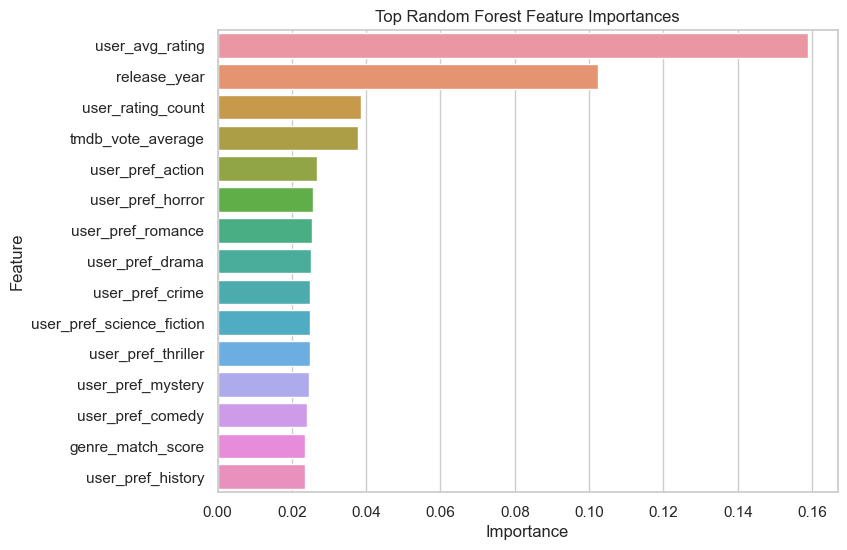

In [15]:
plt.figure(figsize=(8,6))
sns.barplot(data=rf_importance_df.head(15), x="importance", y="feature")
plt.title("Top Random Forest Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

## Model 3: Tuned Neural Network (Keras)


In [16]:
import tensorflow as tf
import keras_tuner as kt

tf.random.set_seed(42)

2025-12-04 01:34:00.679924: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
X_train_dense = X_train.toarray().astype(np.float32)
X_test_dense = X_test.toarray().astype(np.float32)
X_train_dense.shape, X_test_dense.shape

((79619, 345), (20381, 345))

In [18]:
def build_dnn_model(hp: kt.HyperParameters):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(X_train_dense.shape[1],)))
    num_layers = hp.Int("num_layers", min_value=2, max_value=4)
    for i in range(num_layers):
        units = hp.Int(f"units_{i}", min_value=64, max_value=256, step=64)
        model.add(tf.keras.layers.Dense(units, activation="relu"))
        dropout_rate = hp.Float(f"dropout_{i}", min_value=0.0, max_value=0.5, step=0.1)
        if dropout_rate > 0:
            model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(1, activation="linear"))
    learning_rate = hp.Choice("learning_rate", values=[1e-2, 5e-3, 1e-3])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mse",
        metrics=[tf.keras.metrics.MeanAbsoluteError()],
    )
    return model

In [19]:
tuner = kt.Hyperband(
    build_dnn_model,
    objective="val_loss",
    max_epochs=15,
    factor=3,
    directory=str(Path("..") / "tuner_logs"),
    project_name="dnn_recommender",
    overwrite=True,
)
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
tuner.search(X_train_dense, y_train, validation_split=0.2, epochs=30, batch_size=256, callbacks=[stop_early], verbose=1)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

Trial 30 Complete [00h 00m 13s]
val_loss: 0.9011343121528625

Best val_loss So Far: 0.8985117077827454
Total elapsed time: 00h 03m 04s


{'num_layers': 4,
 'units_0': 256,
 'dropout_0': 0.30000000000000004,
 'units_1': 256,
 'dropout_1': 0.0,
 'learning_rate': 0.005,
 'units_2': 128,
 'dropout_2': 0.0,
 'units_3': 64,
 'dropout_3': 0.1,
 'tuner/epochs': 15,
 'tuner/initial_epoch': 5,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0021'}

In [20]:
best_model = tuner.hypermodel.build(best_hps)
final_early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
history = best_model.fit(
    X_train_dense,
    y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=256,
    callbacks=[final_early_stop],
    verbose=1,
)

Epoch 1/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.3178 - mean_absolute_error: 0.9023 - val_loss: 0.9708 - val_mean_absolute_error: 0.8038
Epoch 2/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0503 - mean_absolute_error: 0.8193 - val_loss: 0.9240 - val_mean_absolute_error: 0.7710
Epoch 3/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0285 - mean_absolute_error: 0.8095 - val_loss: 0.9071 - val_mean_absolute_error: 0.7650
Epoch 4/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0165 - mean_absolute_error: 0.8038 - val_loss: 0.9025 - val_mean_absolute_error: 0.7577
Epoch 5/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0068 - mean_absolute_error: 0.7999 - val_loss: 0.9108 - val_mean_absolute_error: 0.7568
Epoch 6/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9990 - mean_absolute_error: 0.7961 - val_loss: 0.9013 - val_mean_absolute_error: 0.7572
Epoch 7/20
249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.9913 - mean_absolute_error: 0.7929 - v

In [21]:
dnn_pred = best_model.predict(X_test_dense, batch_size=256).flatten()
dnn_metrics = evaluate_regression(y_test, dnn_pred)
dnn_metrics

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


{'rmse': 1.0777847195322008, 'mae': 0.8603377938270569}

In [22]:
dnn_cold_metrics = evaluate_regression(y_test[knn_cold_mask], dnn_pred[knn_cold_mask]) if knn_cold_mask.any() else {}
dnn_warm_metrics = evaluate_regression(y_test[~knn_cold_mask], dnn_pred[~knn_cold_mask])
dnn_cold_metrics, dnn_warm_metrics

({'rmse': 1.2304950529647767, 'mae': 0.9961420893669128},
 {'rmse': 1.0727958549454992, 'mae': 0.8562043905258179})

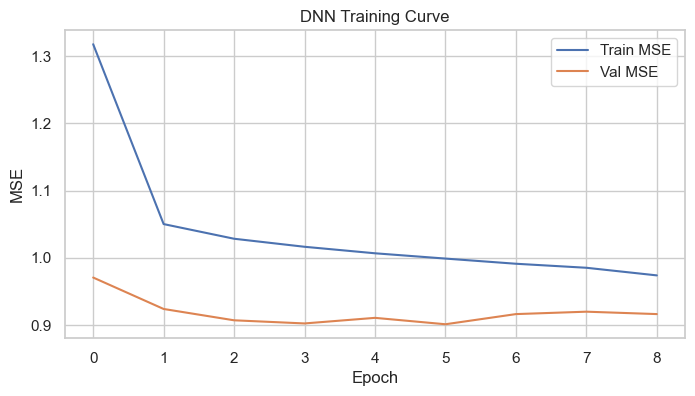

In [23]:
history_df = pd.DataFrame(history.history)
plt.figure(figsize=(8,4))
plt.plot(history_df["loss"], label="Train MSE")
plt.plot(history_df["val_loss"], label="Val MSE")
plt.title("DNN Training Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

## 4. Model Comparison


In [24]:
def safe_metrics(metrics_dict):
    return {
        "rmse": metrics_dict.get("rmse") if metrics_dict else np.nan,
        "mae": metrics_dict.get("mae") if metrics_dict else np.nan,
    }

comparison_rows = []
comparison_rows.append({"model": "KNN", "segment": "overall", **safe_metrics(knn_metrics)})
comparison_rows.append({"model": "KNN", "segment": "warm", **safe_metrics(knn_warm_metrics)})
comparison_rows.append({"model": "KNN", "segment": "cold_start", **safe_metrics(knn_cold_metrics)})
comparison_rows.append({"model": "Random Forest", "segment": "overall", **safe_metrics(rf_metrics)})
comparison_rows.append({"model": "Random Forest", "segment": "warm", **safe_metrics(rf_warm_metrics)})
comparison_rows.append({"model": "Random Forest", "segment": "cold_start", **safe_metrics(rf_cold_metrics)})
comparison_rows.append({"model": "Neural Network", "segment": "overall", **safe_metrics(dnn_metrics)})
comparison_rows.append({"model": "Neural Network", "segment": "warm", **safe_metrics(dnn_warm_metrics)})
comparison_rows.append({"model": "Neural Network", "segment": "cold_start", **safe_metrics(dnn_cold_metrics)})

comparison_df = pd.DataFrame(comparison_rows)
comparison_df = comparison_df.assign(rmse=lambda df: df["rmse"].round(3), mae=lambda df: df["mae"].round(3))
comparison_df

,model,segment,rmse,mae
0,KNN,overall,1.123,0.883
1,KNN,warm,1.118,0.879
2,KNN,cold_start,1.273,1.004
3,Random Forest,overall,1.063,0.847
4,Random Forest,warm,1.059,0.843
5,Random Forest,cold_start,1.201,0.973
6,Neural Network,overall,1.078,0.860
7,Neural Network,warm,1.073,0.856
8,Neural Network,cold_start,1.230,0.996


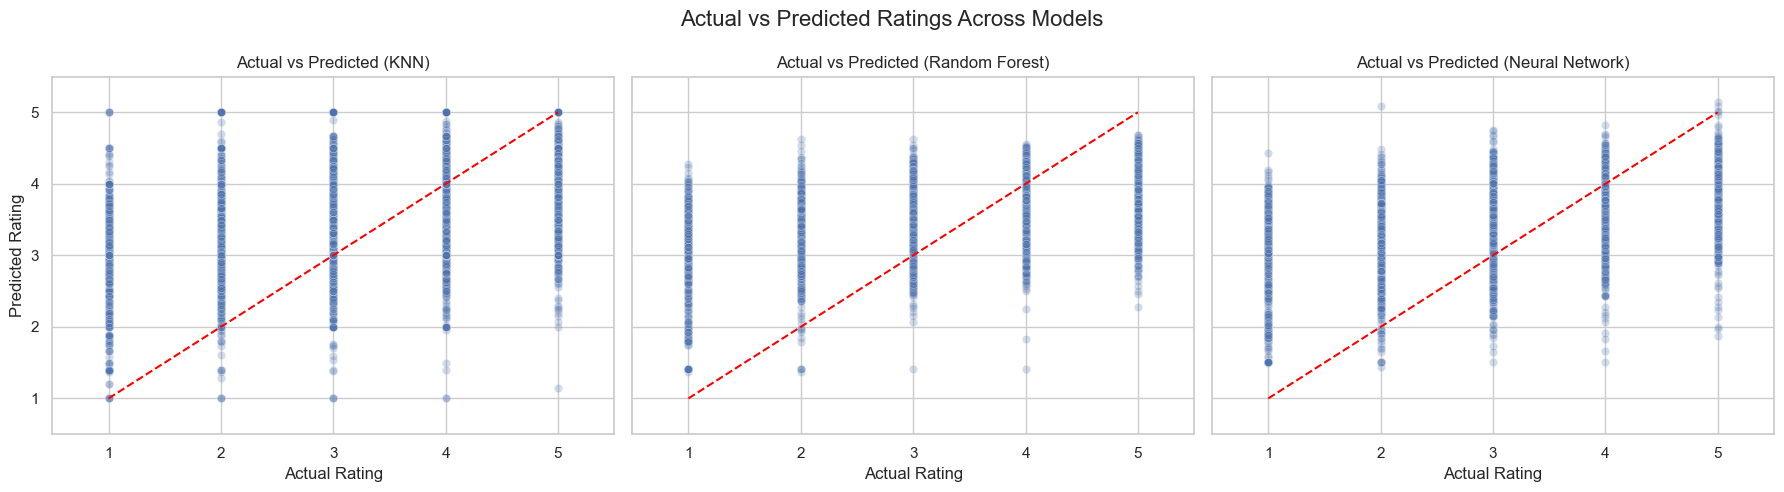

In [25]:
comparison_preds = pd.DataFrame({
    "actual": y_test,
    "KNN": knn_pred,
    "Random Forest": rf_pred,
    "Neural Network": dnn_pred,
})

models = ["KNN", "Random Forest", "Neural Network"]
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)
for ax, model_name in zip(axes, models):
    sample_size = min(5000, len(comparison_preds))
    sample_df = comparison_preds.sample(sample_size, random_state=42)
    sns.scatterplot(data=sample_df, x="actual", y=model_name, alpha=0.25, ax=ax)
    ax.plot([1, 5], [1, 5], color="red", linestyle="--")
    ax.set_title(f"Actual vs Predicted ({model_name})")
    ax.set_xlabel("Actual Rating")
    ax.set_ylabel("Predicted Rating")

fig.suptitle("Actual vs Predicted Ratings Across Models", fontsize=16)
axes[0].set_xlim(0.5, 5.5)
axes[0].set_ylim(0.5, 5.5)
plt.tight_layout()
plt.show()

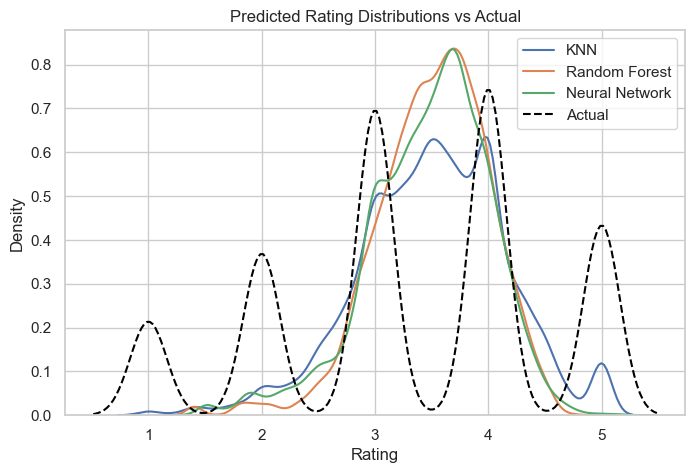

In [26]:
plt.figure(figsize=(8,5))
for model_name in models:
    sns.kdeplot(comparison_preds[model_name], label=model_name, fill=False)
sns.kdeplot(comparison_preds["actual"], label="Actual", linestyle="--", color="black")
plt.title("Predicted Rating Distributions vs Actual")
plt.xlabel("Rating")
plt.ylabel("Density")
plt.legend()
plt.show()

### Key Findings
- **Random Forest** achieves the lowest RMSE/MAE overall (1.063/0.847) and for warm catalog items while remaining interpretable through its top drivers: user average rating, release year, and genre match score.
- **Neural network** nearly matches the tree model (1.078/0.860 overall) thanks to the text-enhanced features, making it a promising path once richer metadata is available.
- **Cosine KNN** trails on cold-start titles (RMSE 1.27) but remains a lightweight benchmark that quickly validates data integrity and pipeline assumptions.
- Predicted distributions show the Random Forest and neural models tracking the heavy concentration of 4–5 star ratings more closely than KNN, improving calibration.


### Business Recommendations
- Deploy the Random Forest pipeline for production scoring now, using its feature importances to guide content merchandising while the neural network remains an R&D track for metadata-heavy launches.
- For catalog entries with <5 historical ratings, prioritize enriched metadata (genres, overview text) and collect quick thumbs feedback to keep cold-start inputs fresh.
- Surface high genre match titles with strong predicted ratings in personalized carousels to lift engagement and reduce search friction.
- Continue monitoring RMSE/MAE by freshness cohort and compare Random Forest vs. neural predictions to ensure recommendations stay calibrated as new releases enter the catalog.


### Next Steps
1. Integrate A/B tested exploration strategies (e.g., bandits) to further mitigate cold-start uncertainty.
2. Extend the feature set with session-level context (time of day, device) to personalize moment-to-moment suggestions.
3. Automate retraining cadence with ML pipelines so that new ratings and content updates flow into refreshed models.
